### Connect to drive, import libraries, set seed, set directories

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/ANDLPROJ2

/gdrive/MyDrive/ANDLPROJ2


In [ ]:
import tensorflow as tf
import numpy as np
import math
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 4

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.9.2


In [ ]:
ROOT = '/gdrive/MyDrive/ANDLPROJ2'
DATA_DIR = os.path.join(ROOT,'training_dataset_homework2')

print(f'contenuto di DATA_DIR ({str(DATA_DIR)}): {os.listdir(DATA_DIR)}')

contenuto di DATA_DIR (/gdrive/MyDrive/ANDLPROJ2/training_dataset_homework2): ['x_train.npy', 'y_train.npy']


### Import data

x_train shape: (2429, 36, 6)
y_train shape: (2429,)
y_train:  [ 0  0  0 ... 11 11 11]
classes:  {0: 'Wish', 1: 'Another', 2: 'Comfortably', 3: 'Money', 4: 'Breathe', 5: 'Time', 6: 'Brain', 7: 'Echoes', 8: 'Wearing', 9: 'Sorrow', 10: 'Hey', 11: 'Shine'}
classes counts:  {0: 34, 1: 123, 2: 270, 3: 381, 4: 62, 5: 153, 6: 313, 7: 68, 8: 120, 9: 777, 10: 77, 11: 51}


Text(0.5, 1.0, 'Fig.1: Histogram of class occurrences')

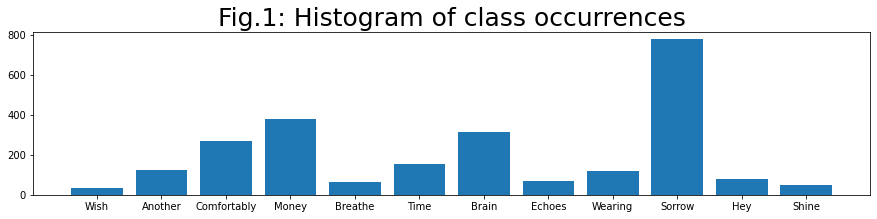

In [ ]:
X = np.load(os.path.join(DATA_DIR,'x_train.npy'))
print(f'x_train shape: {X.shape}')
Y = np.load(os.path.join(DATA_DIR,'y_train.npy'))
print(f'y_train shape: {Y.shape}')


classes = {0:'Wish',1:'Another',2:'Comfortably',3:'Money',4:'Breathe',5:'Time',
           6:'Brain',7:'Echoes',8:'Wearing',9:'Sorrow',10:'Hey',11:'Shine'}
classes_counts = {}
for i in range(12):
    classes_counts[i] = np.count_nonzero(Y==i)

print('y_train: ', Y)
print('classes: ',classes)
print('classes counts: ',classes_counts)

_= plt.figure(figsize=(15,3))
_= plt.bar(classes.values(),classes_counts.values())
plt.title('Fig.1: Histogram of class occurrences', fontsize=25)

## Data preprocessing

### Standardization

In [ ]:
# Do you want to standardize the samples? [0 = No, 1 = Yes]
standardize = 1

if standardize == 1:
  for i,sample in enumerate(X):
      mean_sample = np.mean(sample)
      std_sample = np.std(sample)
      X[i] = (sample-mean_sample)/std_sample

### Adding features from the frequency domain

In [ ]:
# Do you want to add 2 channels with the fourier transform? (rho, theta)
transform = 1

if transform == 1:
  X_mean_chs = np.mean(X, axis=-1)             
  absft = np.zeros(X_mean_chs.shape)
  phaseft = np.zeros(X_mean_chs.shape)

  for i,sample in enumerate(X_mean_chs):
    X_mean_chs = np.fft.fft(sample)
    absft[i] = abs(X_mean_chs)
    phaseft[i] = np.angle(X_mean_chs)
  absft = np.expand_dims(absft, axis=-1)
  phaseft = np.expand_dims(phaseft, axis=-1)
  X = np.concatenate((X,absft),axis=-1)        
  X = np.concatenate((X,phaseft),axis=-1)
  print(f'X shape: {X.shape}')

X shape: (2429, 36, 8)


### Training/validation subsets splitting + categorical labels

In [ ]:
### TRAIN-VAL SPLIT
x_train, x_val, y_train , y_val = train_test_split(
    X, Y, test_size = 0.2, random_state = seed
)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {len(y_train)}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {len(y_val)}')

train_classes_counts = {}
val_classes_counts = {}
for i in range(12):
    train_classes_counts[i] = np.count_nonzero(y_train==i)
    val_classes_counts[i] = np.count_nonzero(y_val==i)

    #### TURN LABELS INTO CATEGORICAL
caty_train = tfk.utils.to_categorical(y_train)
caty_val = tfk.utils.to_categorical(y_val)

print(f'first categorical label (from training set):\n->>> {caty_train[0]}')

x_train shape: (1943, 36, 8)
y_train shape: 1943
x_val shape: (486, 36, 8)
y_val shape: 486
first categorical label (from training set):
->>> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### Class weights computation

In [ ]:
#### CLASS WEIGHTS COMPUTATION (ON TRAINING SET!!)
labels = [i for i in range(12)]; print(f'LABELS: {labels}')
print(f'CLASSES: {classes}')
print(f'TRAIN_CLASSES_COUNTS: {train_classes_counts}')

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = labels,                # array of the classes occurring,
    y = np.array(y_train))     

class_weights_dict = dict(zip(labels, class_weights.round(3))) #showing only 3 decimals
print(f'\n->>> CLASS WEIGHTS: {class_weights_dict}') 

LABELS: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
CLASSES: {0: 'Wish', 1: 'Another', 2: 'Comfortably', 3: 'Money', 4: 'Breathe', 5: 'Time', 6: 'Brain', 7: 'Echoes', 8: 'Wearing', 9: 'Sorrow', 10: 'Hey', 11: 'Shine'}
TRAIN_CLASSES_COUNTS: {0: 28, 1: 100, 2: 210, 3: 307, 4: 48, 5: 122, 6: 246, 7: 48, 8: 103, 9: 626, 10: 61, 11: 44}

->>> CLASS WEIGHTS: {0: 5.783, 1: 1.619, 2: 0.771, 3: 0.527, 4: 3.373, 5: 1.327, 6: 0.658, 7: 3.373, 8: 1.572, 9: 0.259, 10: 2.654, 11: 3.68}


### Visualization

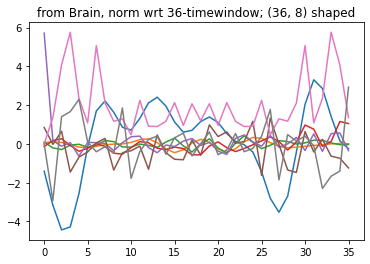

In [ ]:
# DRAW m_th sample
m = 2

_= plt.figure()
_= plt.plot(x_train[m])
_= plt.title(f'from {classes[y_train[m]]}, norm wrt 36-timewindow; {x_train[m].shape} shaped')

## Training with 1D-CNN

### Callbacks definition

In [ ]:
### CALLBACKS
cb_redlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.2,
    patience = 7,
    verbose = 1,
    mode = "max"
)

cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 20,
    mode = "max",
    restore_best_weights = True)


cbs = [cb_redlr, cb_earlystop]

### Architecture

In [ ]:
def CNN1D_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    classifier = tfkl.Dense(1024, activation='relu')(dropout)
    dropout2 = tfkl.Dropout(.3, seed=seed)(classifier)
    output_layer = tfkl.Dense(no_classes, activation='softmax')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    opt = tf.keras.optimizers.Adam(
      learning_rate = 2e-4,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08,
      amsgrad=False,
      name="Adam",
    )
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
input_shape = x_train.shape[1:]
no_classes = caty_train.shape[-1]
print(f'\n\nInput shape: {input_shape}')
print(f'Number of classes: {no_classes}')

model = CNN1D_classifier(input_shape, no_classes)

epochs = 200
batch_size = 32 



Input shape: (36, 8)
Number of classes: 12


### Model fitting

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = caty_train,
    batch_size = batch_size,
    #class_weight = class_weights_dic
    epochs = epochs,
    validation_data = (x_val,caty_val),
    callbacks = cbs
).history

Epoch 1/200
61/61 [==============================] - 10s 15ms/step - loss: 1.9617 - accuracy: 0.3582 - val_loss: 1.7295 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 0s 6ms/step - loss: 1.4606 - accuracy: 0.5234 - val_loss: 1.3626 - val_accuracy: 0.5247 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 0s 6ms/step - loss: 1.2217 - accuracy: 0.5893 - val_loss: 1.2630 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 0s 6ms/step - loss: 1.1509 - accuracy: 0.6114 - val_loss: 1.1481 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 0s 6ms/step - loss: 1.0494 - accuracy: 0.6444 - val_loss: 1.0899 - val_accuracy: 0.6317 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 0s 6ms/step - loss: 1.0021 - accuracy: 0.6552 - val_loss: 1.0661 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 0s 6ms/step - loss: 0

### Results

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
print('Validation accuracy at its best: ',np.max(history['val_accuracy']))

Validation accuracy at its best:  0.6995884776115417


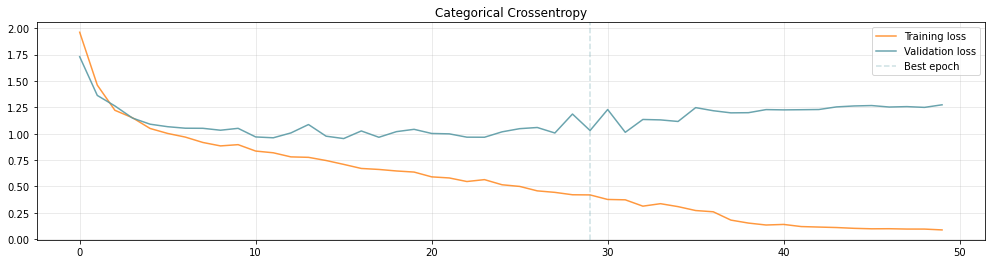

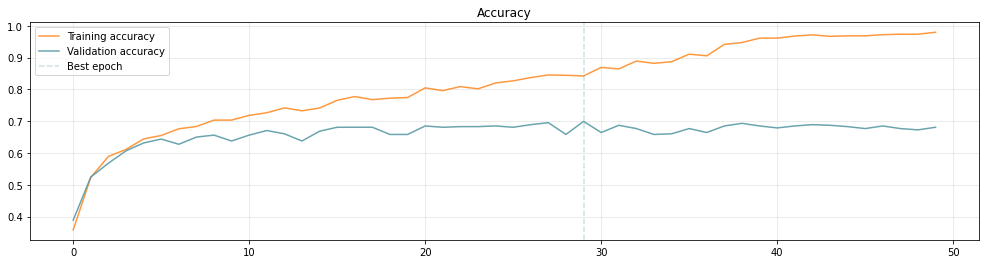

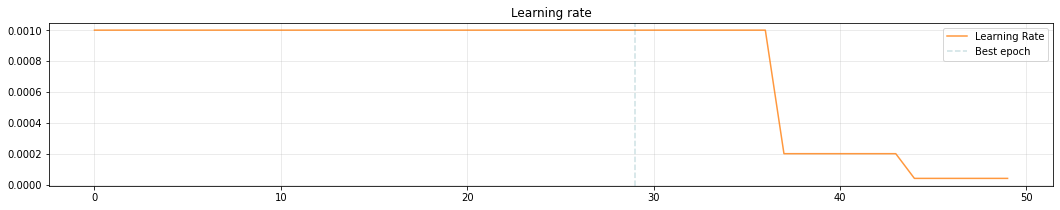

In [ ]:
#### PLOT LOSS
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### PLOT ACCURACY
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### PLOT LEARNING RATE DECAY
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.title('Learning rate')
plt.grid(alpha=.3)
plt.show()

## EXTRA: Tuning a transformer network

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner

### Building the transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# We can stack multiple of those transformer_encoder blocks and we can also proceed to add the final Multi-Layer Perceptron classification head. 
# Apart from a stack of Dense layers, we need to reduce the output tensor of the TransformerEncoder part of our model down to a vector of features for each data point in the current batch.
# A common way to achieve this is to use a pooling layer. For this example, a GlobalAveragePooling1D layer is sufficient.

In [ ]:
def tuner_transformer(hp):
    
    inputs = tfk.Input(shape=input_shape)
    
    num_transformer_blocks = hp.Choice("no_transf_blocks", [4,6])
    head_size = hp.Choice("head_size", [32,64,128])
    num_heads = hp.Choice("no_transf_blocks", [1,4,8,16])
    ff_dim = hp.Choice("ff_dim", [1024,2048])
    dropout = hp.Float("dropout",min_value=0, max_value=0.5)
    mlp_dropout = hp.Float("mlp_dropout",min_value=0, max_value=0.5)
    learning_rate = hp.Float("init_lr", min_value=7e-6, max_value=7e-3)
    
    mlp_units = [128,128]    ###

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(no_classes, activation="softmax")(x)
    
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
    
    opt = tf.keras.optimizers.Adam(
      learning_rate = learning_rate,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08,
      amsgrad=False,
      name="Adam",
    )
   
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

### Search with bayesian optimization

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=tuner_transformer,
    objective=keras_tuner.Objective("val_accuracy", direction="max"),
    max_trials=30,
    num_initial_points=12,
    alpha=0.0001,
    beta=2.6,
    seed=seed,
)

tuner.search(
        x = x_train,
        y = caty_train,
        epochs=epochs,
        batch_size = batch_size,
        #class_weight = class_weights_dict,
        validation_data = (x_val, caty_val),
        callbacks = cbs
             )

Trial 30 Complete [00h 01m 56s]
val_accuracy: 0.5987654328346252

Best val_accuracy So Far: 0.6193415522575378
Total elapsed time: 00h 50m 39s
